# Fraud Detection


### Design Doc

__Scope__

The idea here is to follow this design document to build our initial baseline model and reuse as much code as possible and do so relatively quickly.

I first tested this approach with this data: https://www.kaggle.com/mlg-ulb/creditcardfraud

>The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

>It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

I then tested this approach with a more difficult dataset, which is available here: https://github.com/CapitalOneRecruiting/DS

__Goal__

Predict ```Class``` label, which represents fraudulent activity.

The ```Class``` label is relatively rare, which means our dataset is imbalanced. 

    
__Baseline Feature Engineering__

1. Remove features that entirely null.
2. Deal with missing values.
3. Time based features: hour, day, etc.. (if any).
4. Categorical features should be one-hot encoded (if any).
5. Dollar features should be logged (if any).
6. Non monetary continuous features scaled.
7. Perhaps some row level statistics.
8. Upsampling.

Things to be wary of:

    - leakage
    - features that are in our test set (or production) that may not be in our training data
    - When oversampling, do not oversample test set.

__Baseline Model and Error Metric__

1. Tree based model, XGboost. The decision to use XGBoost over other tree implementations comes down to speed, flexibility, and performance. XGBoost allows for custom optimization functions and parallelized for speed. 

2. I think we will be looking at the precision and recall on our two classes as well as AUC. XGBoost allows for the following evaluation metrics: log loss, auc, and auc pr (precision and recall).

    - Binary classification problem
    - Imbalanced data
    - True positive and/or False positive rate may be important to judge performance

__Project Structure__

```
\utils
- utils.py
- models.py
- pipeline.py
```

__Steps__

1. Clean data.
2. Pass clean data through Pipeline.
3. Train and evaluate baseline model.

Repeat process but with random oversampling.


## Dataset A
______

__Processing__

Cleaning and feature engineering with dataset A is pretty straightforward, probably because the features themselves are derived from a PCA transformation.

```python
class Processing(object):
    """
    Contains:
        - classmethods for constructing different feature types (One Hot Encode, Log, Scale)
    """


    dollar_features = ['Amount']
    time_features = ['Time']

    @classmethod
    def original_constructor(cls, feature):
        return Pipeline([('selector', FeatureSelector(column=feature))
                         ])

    @classmethod
    def categorical_constructor(cls, feature):
        return Pipeline([('selector', FeatureSelector(column=feature)),
                         ('standard', OneHotEncoder()),
                        ])

    @classmethod
    def scale_constructor(cls, feature):
        return Pipeline([('selector', FeatureSelector(column=feature)),
                         ('standard', StandardScaler())
                         ])

    @classmethod
    def log_constructor(cls, feature):
        return Pipeline([('selector', LogTransformer(column=feature))
                         ])

    @classmethod
    def clean(cls, data):
        """
        Args: data
        Returns: cleaned data
        """

        for col in cls.dollar_features:
            data.loc[data[col] == 0, col] = 0.01

        return data

    @classmethod
    def features(cls, data):
        """
        Args: data
        Returns: Scikit-Learn pipeline of baseline feature transformations
        """
        base_features = data.columns
        base_features = [b for b in base_features if b not in ['Time','Amount','Class']]

        # build categorical feature dicionary
        feature_pipe = dict()

        # build continuous log features
        for col in cls.dollar_features:
            feature_pipe[col] = cls.log_constructor(col)

        # build continuous scale features
        for col in cls.time_features:
            feature_pipe[col] = cls.scale_constructor(col)

        # row stats
        for col in base_features:
            feature_pipe[col] = cls.original_constructor(col)

        feature_list = []
        for key in feature_pipe.keys():
            feature_list.append((key, feature_pipe[key]))

        features = FeatureUnion(feature_list)
        pipe = Pipeline([('features', features)])
        return pipe
```
-----

__First Baseline__


The initial model seems to perform relatively well in terms of precision and precision for the fraud class:

```
ROC score: 0.9521513784678161

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28429
           1       0.90      0.52      0.66        52

    accuracy                           1.00     28481
   macro avg       0.95      0.76      0.83     28481
weighted avg       1.00      1.00      1.00     28481

```

To help improve the recall of our model we will use random oversampling with the Python package ```imbalanced-learn,``` I referred to this [documentation](https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html#random-over-sampler).


__Upsampling__

By upsampling our data our original baseline model performs better:

```
ROC score: 0.9791731493031223

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28429
           1       0.76      0.85      0.80        52

    accuracy                           1.00     28481
   macro avg       0.88      0.92      0.90     28481
weighted avg       1.00      1.00      1.00     28481

```

We increased recall on the fraud class label from 0.52 to 0.85. However Precision took a hit. However if we adjust the threshold of prediction we can concentrate on the cases we are most confident in. For example adjusting the prediction threshold to 0.8 we get 90% of cases. On the other hand we only capture a small percentage of overall fraud cases. 


If we adjust the prediction threshold we can focus on those case we have the most confidence in:

```
[(0.1, 0.0018258426966292136), 
 (0.2, 0.0344311377245509),
 (0.3, 0.20087336244541484),
 (0.4, 0.5056179775280899),
 (0.5, 0.7586206896551724),
 (0.6, 0.8148148148148148),
 (0.7, 0.86),
 (0.8, 0.8913043478260869),
 (0.9, 1)]

```

## Dataset B
-------

__Processing__

This dataset is in a non-valid json format, i.e. an array of json which is around 500mb. I would prefer to have this data in csv format. We can do this the slow and inefficient way by reading in the invalid json as a list of dictionaries, create a Pandas dataframe, then save to csv. This loads everything into memory. My wimpy Macbook Air, with very little memory has begged me not to do this. We can create a generator and iteratively write to file. This takes around a quarter of the time.

The data is much more complex:

```
accountNumber                 int64
accountOpenDate              object
acqCountry                   object
availableMoney              float64
cardCVV                       int64
cardLast4Digits               int64
cardPresent                    bool
creditLimit                 float64
currentBalance              float64
currentExpDate               object
customerId                    int64
dateOfLastAddressChange      object
echoBuffer                  float64
enteredCVV                    int64
expirationDateKeyInMatch       bool
isFraud                        bool
merchantCategoryCode         object
merchantCity                float64
merchantCountryCode          object
merchantName                 object
merchantState               float64
merchantZip                 float64
posConditionCode            float64
posEntryMode                float64
posOnPremises               float64
recurringAuthInd            float64
transactionAmount           float64
transactionDateTime          object
transactionType              object
```


----



__First Baseline__

This model performs very poorly, even with when building new features. Recall is 0.

```
ROC score: 0.7521769107152564

              precision    recall  f1-score   support

       False       0.98      1.00      0.99     63033
        True       0.00      0.00      0.00      1159

    accuracy                           0.98     64192
   macro avg       0.49      0.50      0.50     64192
weighted avg       0.96      0.98      0.97     64192
```


__Upsampling__


```
ROC score: 0.76435274388984

              precision    recall  f1-score   support

       False       0.99      0.72      0.83     63033
        True       0.04      0.67      0.08      1159

    accuracy                           0.72     64192
   macro avg       0.52      0.69      0.46     64192
weighted avg       0.97      0.72      0.82     64192
```

While this model is not that great we have made progress, recall increased from 0 to 0.67. We can adjust our threshold. For example if we make our prediction threshold probability 0.9, we catch 1:4 of fraud cases. However this represents a small fraction of overall fraud cases.

```
[(0.1, 0.020287212217916573),
 (0.2, 0.02280499403063599), 
 (0.3, 0.027410849475278023), 
 (0.4, 0.033790348699125554), 
 (0.5, 0.041666666666666664), 
 (0.6, 0.05222050676596131), 
 (0.7, 0.0678139725466093), 
 (0.8, 0.08691674290942361), 
 (0.9, 0.25)]
```
-----




__Additional Issues__

While we can adjust our prediction threshold to caputure the majority of cases for small percentage of fraud cases, the question I ask myself is: Are these the most risky cases, i.e. most costly?


__Things that I did not do, but if I had time I would have__

1. Synthetic Minority Oversampling Technique (SMOTE), this method seems to take a long time to fit; therefore I decided not to pursue it.

https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html

```python
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
```

2. Hyperparameter optimization. I think the important issue was resampling the data. I know I could have spent some significant time on hyperparameter optimization.

3. Cross-validation. I think there would have been additional complexity combining cross-validation with random oversampling and by extension time spent on doing just that; therefore I kept things simple. However I think cross-validation would improve the performance here since we are using a tree based approach, which has issues with variance.

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from collections import Counter
from utils.models import Processing, Models, Metrics
from utils.utils import IO

sns.set(style="dark")
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Dataset A

In [2]:
df = pd.read_csv('data/creditcard.csv')

In [3]:
df.shape

(284807, 31)

In [4]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [5]:
df['Class'].describe()

count    284807.000000
mean          0.001727
std           0.041527
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Class, dtype: float64

In [6]:
Counter(df['Class'])

Counter({0: 284315, 1: 492})

Text(0.5, 0, 'Amount')

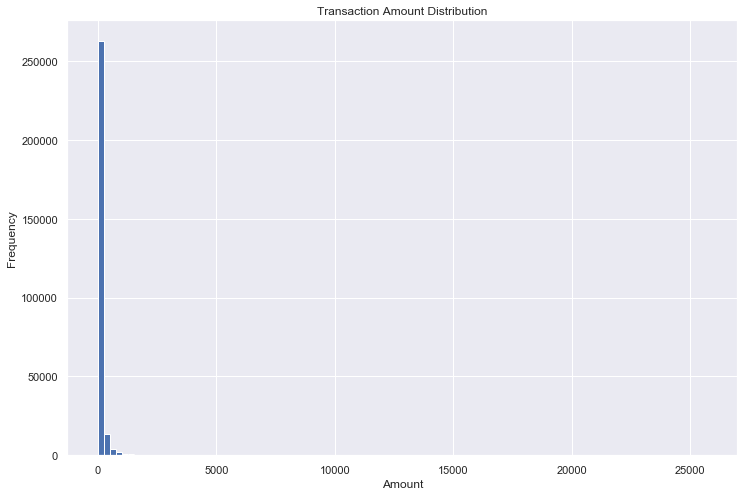

In [7]:
df['Amount'].hist(bins = 100, figsize=(12, 8))
plt.title('Transaction Amount Distribution')
plt.ylabel('Frequency')
plt.xlabel('Amount')

In [8]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [9]:
# clean train
train = Processing.clean(df)

In [10]:
# create feature and target 
X = train.drop(['Class'], axis = 1)
y = train['Class']

In [11]:
pipe = Processing.features(X)

In [12]:
pipe.fit(X)
X = pipe.transform(X)

In [13]:
Models.baseline(X, y)

[0]	train-auc:0.877393	valid-auc:0.924628
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[1]	train-auc:0.888379	valid-auc:0.924586
[2]	train-auc:0.900588	valid-auc:0.92446
[3]	train-auc:0.900526	valid-auc:0.924418
[4]	train-auc:0.918312	valid-auc:0.936755
[5]	train-auc:0.918083	valid-auc:0.936622
[6]	train-auc:0.922425	valid-auc:0.942932
[7]	train-auc:0.951965	valid-auc:0.945401
[8]	train-auc:0.951844	valid-auc:0.945301
[9]	train-auc:0.95181	valid-auc:0.945292
[10]	train-auc:0.951271	valid-auc:0.944774
[11]	train-auc:0.95129	valid-auc:0.944797
[12]	train-auc:0.952377	valid-auc:0.94455
[13]	train-auc:0.952432	valid-auc:0.951237
[14]	train-auc:0.952465	valid-auc:0.951254
[15]	train-auc:0.952338	valid-auc:0.95116
[16]	train-auc:0.953736	valid-auc:0.951134
[17]	train-auc:0.953752	valid-auc:0.951078
[18]	train-auc:0.953564	valid-auc:0.950983
[19]	train-auc:0.953592	valid-auc:0.950945
[20]	train-a

In [14]:
Models.resample_baseline(X, y)

[0]	train-auc:0.993238	valid-auc:0.945229
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[1]	train-auc:0.994024	valid-auc:0.947909
[2]	train-auc:0.998402	valid-auc:0.962996
[3]	train-auc:0.99925	valid-auc:0.977756
[4]	train-auc:0.999472	valid-auc:0.987629
[5]	train-auc:0.999727	valid-auc:0.986892
[6]	train-auc:0.999763	valid-auc:0.986536
[7]	train-auc:0.99978	valid-auc:0.984592
[8]	train-auc:0.99979	valid-auc:0.98276
[9]	train-auc:0.999822	valid-auc:0.983861
[10]	train-auc:0.999835	valid-auc:0.985182
[11]	train-auc:0.999844	valid-auc:0.983808
[12]	train-auc:0.999847	valid-auc:0.984058
[13]	train-auc:0.999848	valid-auc:0.984244
[14]	train-auc:0.999849	valid-auc:0.982994
Stopping. Best iteration:
[4]	train-auc:0.999472	valid-auc:0.987629

ROC score: 0.9791731493031223
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28429
           1      

## Dataset B

In [15]:
IO.write_csv('data/transactions.txt', 'data/processed_transactions.csv')

In [16]:
df2 = pd.read_csv('data/processed_transactions.csv')

In [17]:
df2.shape

(641914, 29)

In [18]:
df2.head()

,accountNumber,accountOpenDate,acqCountry,availableMoney,cardCVV,cardLast4Digits,cardPresent,creditLimit,currentBalance,currentExpDate,...,merchantName,merchantState,merchantZip,posConditionCode,posEntryMode,posOnPremises,recurringAuthInd,transactionAmount,transactionDateTime,transactionType
0,733493772,2014-08-03,US,5000.00,492,9184,False,5000.0,0.00,04/2020,...,Lyft,NaN,NaN,1.0,5.0,NaN,NaN,111.33,2016-01-08T19:04:50,PURCHASE
1,733493772,2014-08-03,US,4888.67,492,9184,False,5000.0,111.33,06/2023,...,Uber,NaN,NaN,1.0,9.0,NaN,NaN,24.75,2016-01-09T22:32:39,PURCHASE
2,733493772,2014-08-03,US,4863.92,492,9184,False,5000.0,136.08,12/2027,...,Lyft,NaN,NaN,1.0,5.0,NaN,NaN,187.40,2016-01-11T13:36:55,PURCHASE
3,733493772,2014-08-03,US,4676.52,492,9184,False,5000.0,323.48,09/2029,...,Lyft,NaN,NaN,1.0,2.0,NaN,NaN,227.34,2016-01-11T22:47:46,PURCHASE
4,733493772,2014-08-03,US,4449.18,492,9184,False,5000.0,550.82,10/2024,...,Lyft,NaN,NaN,1.0,2.0,NaN,NaN,0.00,2016-01-16T01:41:11,ADDRESS_VERIFICATION


In [19]:
df2.dtypes

accountNumber                 int64
accountOpenDate              object
acqCountry                   object
availableMoney              float64
cardCVV                       int64
cardLast4Digits               int64
cardPresent                    bool
creditLimit                 float64
currentBalance              float64
currentExpDate               object
customerId                    int64
dateOfLastAddressChange      object
echoBuffer                  float64
enteredCVV                    int64
expirationDateKeyInMatch       bool
isFraud                        bool
merchantCategoryCode         object
merchantCity                float64
merchantCountryCode          object
merchantName                 object
merchantState               float64
merchantZip                 float64
posConditionCode            float64
posEntryMode                float64
posOnPremises               float64
recurringAuthInd            float64
transactionAmount           float64
transactionDateTime         

In [20]:
df2.groupby('transactionType').mean()['isFraud']

transactionType
ADDRESS_VERIFICATION    0.005280
PURCHASE                0.017924
REVERSAL                0.018129
Name: isFraud, dtype: float64

In [21]:
df2.groupby('merchantCategoryCode').mean()['isFraud']

merchantCategoryCode
airline                 0.020621
auto                    0.020794
cable/phone             0.000000
entertainment           0.013422
fastfood                0.017165
food                    0.020368
food_delivery           0.000000
fuel                    0.000000
furniture               0.012799
gym                     0.000000
health                  0.019172
hotels                  0.028410
mobileapps              0.000000
online_gifts            0.019791
online_retail           0.022586
online_subscriptions    0.000000
personal care           0.012059
rideshare               0.022245
subscriptions           0.009523
Name: isFraud, dtype: float64

In [22]:
# clean train
train = Processing.clean_b(df2)

In [23]:
# create feature and target 
X = train.drop(['isFraud'], axis = 1)
y = train['isFraud']

In [24]:
pipe = Processing.features_b(X)

In [25]:
pipe.fit(X)
X = pipe.transform(X)

In [26]:
Models.baseline(X, y)

[0]	train-auc:0.711197	valid-auc:0.715886
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[1]	train-auc:0.725325	valid-auc:0.72898
[2]	train-auc:0.718991	valid-auc:0.720807
[3]	train-auc:0.735397	valid-auc:0.739211
[4]	train-auc:0.739788	valid-auc:0.74218
[5]	train-auc:0.737932	valid-auc:0.742261
[6]	train-auc:0.73366	valid-auc:0.737407
[7]	train-auc:0.739364	valid-auc:0.74483
[8]	train-auc:0.73347	valid-auc:0.739813
[9]	train-auc:0.744236	valid-auc:0.747347
[10]	train-auc:0.744497	valid-auc:0.747683
[11]	train-auc:0.747443	valid-auc:0.746905
[12]	train-auc:0.748533	valid-auc:0.745814
[13]	train-auc:0.751655	valid-auc:0.750378
[14]	train-auc:0.751436	valid-auc:0.75002
[15]	train-auc:0.750727	valid-auc:0.748555
[16]	train-auc:0.751451	valid-auc:0.749519
[17]	train-auc:0.75631	valid-auc:0.754637
[18]	train-auc:0.758055	valid-auc:0.75708
[19]	train-auc:0.75924	valid-auc:0.758062
[20]	train-auc:0

In [27]:
Models.resample_baseline(X, y)

[0]	train-auc:0.746234	valid-auc:0.721182
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[1]	train-auc:0.754903	valid-auc:0.730325
[2]	train-auc:0.744755	valid-auc:0.72713
[3]	train-auc:0.745501	valid-auc:0.724645
[4]	train-auc:0.753988	valid-auc:0.731074
[5]	train-auc:0.751926	valid-auc:0.729564
[6]	train-auc:0.75127	valid-auc:0.728067
[7]	train-auc:0.748558	valid-auc:0.728534
[8]	train-auc:0.765839	valid-auc:0.742123
[9]	train-auc:0.76589	valid-auc:0.744677
[10]	train-auc:0.764293	valid-auc:0.744103
[11]	train-auc:0.772693	valid-auc:0.750703
[12]	train-auc:0.77901	valid-auc:0.754283
[13]	train-auc:0.779379	valid-auc:0.754239
[14]	train-auc:0.779757	valid-auc:0.753275
[15]	train-auc:0.784425	valid-auc:0.754912
[16]	train-auc:0.784175	valid-auc:0.754413
[17]	train-auc:0.786084	valid-auc:0.754784
[18]	train-auc:0.786846	valid-auc:0.755044
[19]	train-auc:0.787807	valid-auc:0.756198
[20]	train-